## EDA

The objective of this notebook is to perform an EDA to the crypto data

https://blog.mathquant.com/2024/02/26/an-essential-tool-in-the-field-of-quantitative-trading-fmz-quant-data-exploration-module.html

In [4]:
import polars as pl
from pathlib import Path
from tqdm import notebook
from contextlib import contextmanager
import ta
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from profilehooks import profile
from statsmodels.tsa.stattools import adfuller

In [5]:
@contextmanager
def timed_operation():
    start = time.time()
    yield
    end = time.time()
    print(f"The operation took {end - start:.5f} seconds.")


### Directories

In [6]:
base_path = Path()
file_path = base_path / 'data/candles/binance/futures'
parquet_files = list(file_path.glob('*.parquet'))
parquet_files_15m = [file for file in parquet_files if '15m' in file.name]

In [7]:
lazy_frames = {file.name.split('_')[0]: pl.scan_parquet(file) for file in parquet_files_15m}

In [8]:
pl.read_parquet(parquet_files[0]).columns

['date', 'open', 'high', 'low', 'close', 'volume']

### Technical Analysis Metrics

In [28]:
def at_metrics(data, size_window):
    res = dict()
    data = data.to_pandas()
    
    data = data.set_index('date', drop=False)
    
    
    res['description'] = data.describe()

    res['isNull'] = data.isna().sum()

    res['timestampDiff'] = (data.index[1:]-data.index[:-1]).value_counts()
    
    res['rsi'] = ta.momentum.RSIIndicator(data['close'], window=size_window).rsi()
    res['sma'] = ta.trend.SMAIndicator(data['close'], window=size_window).sma_indicator()

    res['ema'] = ta.trend.EMAIndicator(data['close'], window=size_window).ema_indicator()

    bb_indicator = ta.volatility.BollingerBands(data['close'], window=size_window, window_dev=2)
    res['bb_mavg'] = bb_indicator.bollinger_mavg()
    res['bb_hband'] = bb_indicator.bollinger_hband()
    res['bb_lband'] = bb_indicator.bollinger_lband()

    macd_indicator = ta.trend.MACD(data['close'])
    res['macd'] = macd_indicator.macd()
    res['macd_signal'] = macd_indicator.macd_signal()
    res['macd_diff'] = macd_indicator.macd_diff()
    
    res['close'] = data['close']

    return res

In [10]:
def plot_at_metrics(metrics):
    plt.figure(figsize=(14, 12))

    # SMA et EMA
    plt.subplot(3, 2, 1)
    plt.plot(metrics['close'], label='Close', alpha=0.5)
    plt.plot(metrics['sma'], label='SMA', alpha=0.75)
    plt.plot(metrics['ema'], label='EMA', alpha=0.75)
    plt.title('SMA, EMA, and Close Price')
    plt.legend()

    # Bollinger Bands
    plt.subplot(3, 2, 2)
    plt.plot(metrics['close'], label='Close', alpha=0.5)
    plt.plot(metrics['bb_mavg'], label='BB Mavg', linestyle='--')
    plt.fill_between(metrics['bb_mavg'].index, metrics['bb_hband'], metrics['bb_lband'], color='grey', alpha=0.5)
    plt.title('Bollinger Bands and Close Price')
    plt.legend()

    # MACD, Signal MACD, MACD Diff
    plt.subplot(3, 2, 3)
    plt.plot(metrics['macd'], label='MACD', alpha=0.75)
    plt.plot(metrics['macd_signal'], label='MACD Signal', alpha=0.75)
    plt.bar(metrics['macd_diff'].index, metrics['macd_diff'], label='MACD Diff', alpha=0.5)
    plt.title('MACD, MACD Signal, and MACD Diff')
    plt.legend()

    # RSI
    plt.subplot(3, 2, 4)
    plt.plot(metrics['rsi'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', color='red', alpha=0.5) 
    plt.axhline(30, linestyle='--', color='green', alpha=0.5) 
    plt.title('Relative Strength Index (RSI)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
%%time
tickers = []
with open(base_path / 'tickers.txt', 'r') as f:
    tickers.extend(line.strip().split('/')[0][1:].replace(",", "") for line in f)


CPU times: total: 0 ns
Wall time: 23.4 ms


In [12]:
print('No duplicates in tickers') if len(tickers) == len(list(set(tickers))) else 'Duplicates in tickers'

No duplicates in tickers


#### 15m

In [29]:
%%time
results_metrics = {}
for key in lazy_frames.keys():
    if key in tickers:
        results_metrics[key] = at_metrics(lazy_frames[key].fetch(), 20)

CPU times: total: 531 ms
Wall time: 1.9 s


In [14]:
lazy_frames['BTC'].collect().to_pandas()

,date,open,high,low,close,volume
0,2019-09-08 17:45:00+00:00,10000.0,10000.0,10000.0,10000.0,0.002
1,2019-09-08 18:00:00+00:00,10000.0,10000.0,10000.0,10000.0,0.000
2,2019-09-08 18:15:00+00:00,10000.0,10000.0,10000.0,10000.0,0.000
3,2019-09-08 18:30:00+00:00,10000.0,10000.0,10000.0,10000.0,0.000
4,2019-09-08 18:45:00+00:00,10000.0,10000.0,10000.0,10000.0,0.000
...,...,...,...,...,...,...
147093,2023-11-18 23:00:00+00:00,36517.4,36548.9,36502.3,36536.2,933.453
147094,2023-11-18 23:15:00+00:00,36536.2,36581.6,36530.0,36536.1,1382.798
147095,2023-11-18 23:30:00+00:00,36536.0,36583.9,36520.6,36578.1,918.616
147096,2023-11-18 23:45:00+00:00,36578.0,36583.9,36564.0,36580.9,539.913


In [15]:
results_metrics['BTC']['description'].T

,count,mean,std,min,25%,50%,75%,max
open,500.0,10224.04748,116.259287,9984.15,10117.1350,10253.7100,10308.29750,10455.70
high,500.0,10240.10952,115.472698,10000.00,10133.5100,10270.5350,10326.28000,10475.54
low,500.0,10208.88582,117.793339,9884.31,10097.4675,10236.6550,10297.79000,10414.96
close,500.0,10224.38392,116.333737,9986.00,10113.2125,10254.7450,10307.26000,10448.03
volume,500.0,143.30351,65.336624,0.00,86.4990,153.8185,180.70775,381.03


In [16]:
results_metrics['BTC']['isNull']

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [17]:
results_metrics['BTC']['timestampDiff']

date
0 days 00:15:00    499
Name: count, dtype: int64

No missing timestamps

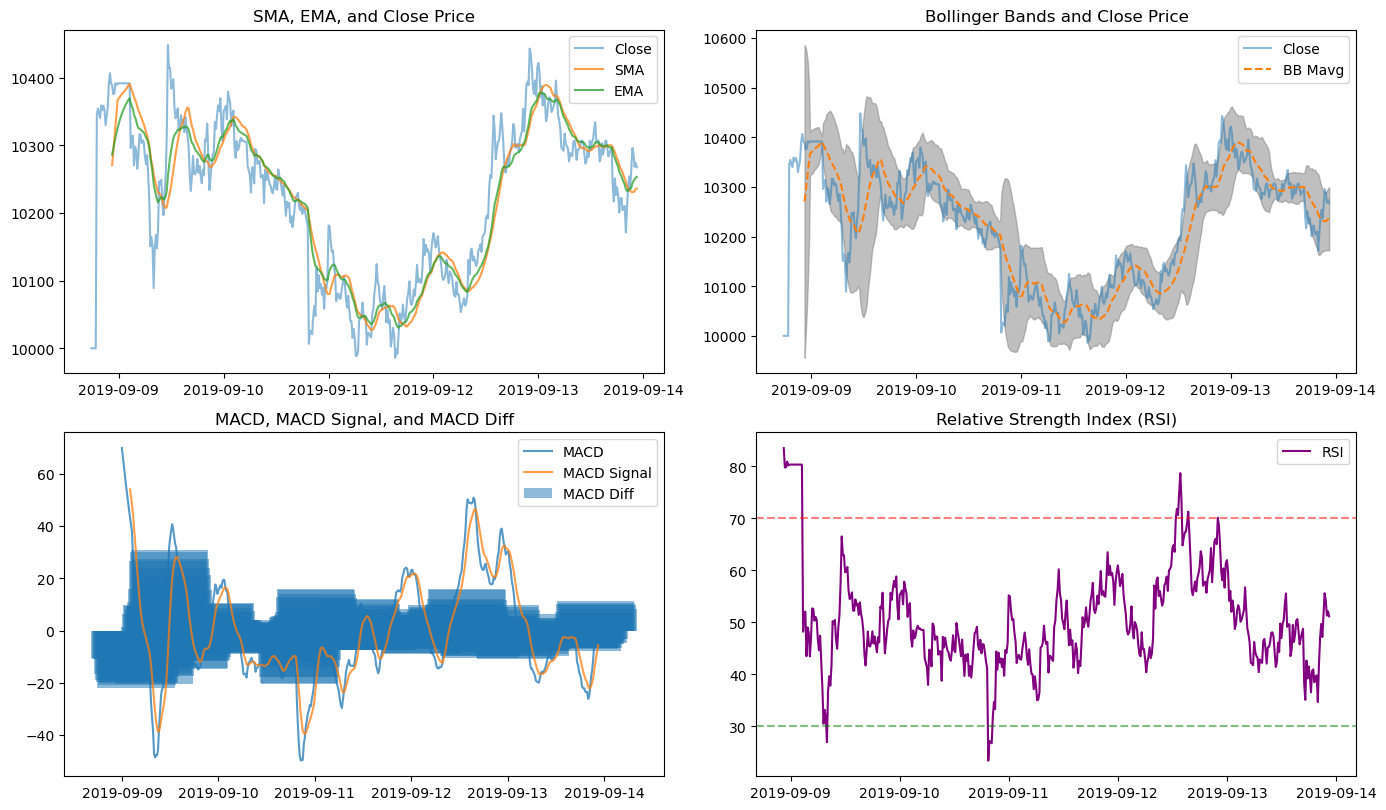

In [18]:
plot_at_metrics(results_metrics['BTC'])

Conservative RSI isn't good for this timestamp ?

In [23]:
print("The time series is likely non-stationary.") if adfuller(results_metrics['BTC']['rsi'].dropna(axis = 0))[1] > 0.05 else print("The time series is likely stationary.")

The time series is likely stationary.


In [30]:
#Simple moving average
print("The time series is likely non-stationary.") if adfuller(results_metrics['BTC']['sma'].dropna(axis = 0))[1] > 0.05 else print("The time series is likely stationary.")

The time series is likely non-stationary.


In [31]:
#Exponantial moving average
print("The time series is likely non-stationary.") if adfuller(results_metrics['BTC']['ema'].dropna(axis = 0))[1] > 0.05 else print("The time series is likely stationary.")

The time series is likely non-stationary.


### Candles

In [32]:
def get_candles_graph(df):
    df = df.to_pandas()
    df = df.set_index('date', drop=False)
    fig = go.Figure(data=[go.Candlestick(x=df.index, open=df['open'], high=df['high'], low=df['low'], close=df['close'])])
    fig.show()

In [34]:
# this code line works more on vscode
# get_candles_graph(lazy_frames['BTC'].fetch())

#### 1d

In [36]:
parquet_files_1d = [file for file in parquet_files if '1d' in file.name]
lazy_frames_1d = {file.name.split('_')[0]: pl.scan_parquet(file) for file in parquet_files_1d}

results_metrics_1d = {}
for key in lazy_frames_1d.keys():
    if key in tickers:
        results_metrics_1d[key] = at_metrics(lazy_frames_1d[key].fetch(), 20)

In [37]:
lazy_frames_1d['BTC'].collect().to_pandas()

,date,open,high,low,close,volume
0,2019-09-08 00:00:00+00:00,10000.00,10412.65,10000.00,10391.63,3096.291
1,2019-09-09 00:00:00+00:00,10316.62,10475.54,10077.22,10307.00,14824.373
2,2019-09-10 00:00:00+00:00,10307.00,10382.97,9940.87,10102.02,9068.955
3,2019-09-11 00:00:00+00:00,10094.27,10293.11,9884.31,10159.55,10897.922
4,2019-09-12 00:00:00+00:00,10163.06,10450.13,10042.12,10415.13,15609.634
...,...,...,...,...,...,...
1528,2023-11-14 00:00:00+00:00,36486.20,36779.90,34446.30,35559.00,397265.800
1529,2023-11-15 00:00:00+00:00,35559.10,38000.00,35388.00,37885.60,423818.570
1530,2023-11-16 00:00:00+00:00,37885.50,37956.50,35486.10,36176.00,434444.366
1531,2023-11-17 00:00:00+00:00,36176.00,37020.50,35868.30,36621.90,319943.051


In [38]:
results_metrics_1d['BTC']['description'].T

,count,mean,std,min,25%,50%,75%,max
open,500.0,11356.262900,6182.057350,4762.280,8200.5000,9407.3700,11375.35250,40638.910
high,500.0,11681.261720,6516.329397,5361.260,8377.8075,9598.5000,11553.00000,42125.510
low,500.0,11027.126160,5834.487469,3621.810,8008.4675,9238.5000,11156.25000,38733.280
close,500.0,11410.487340,6277.624518,4764.650,8200.1500,9418.5150,11393.72000,40637.230
volume,500.0,237795.184934,162875.541290,3096.291,125388.0160,200597.4275,318361.99175,944211.711


In [39]:
results_metrics_1d['BTC']['isNull']

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [40]:
results_metrics_1d['BTC']['timestampDiff']

date
1 days    499
Name: count, dtype: int64

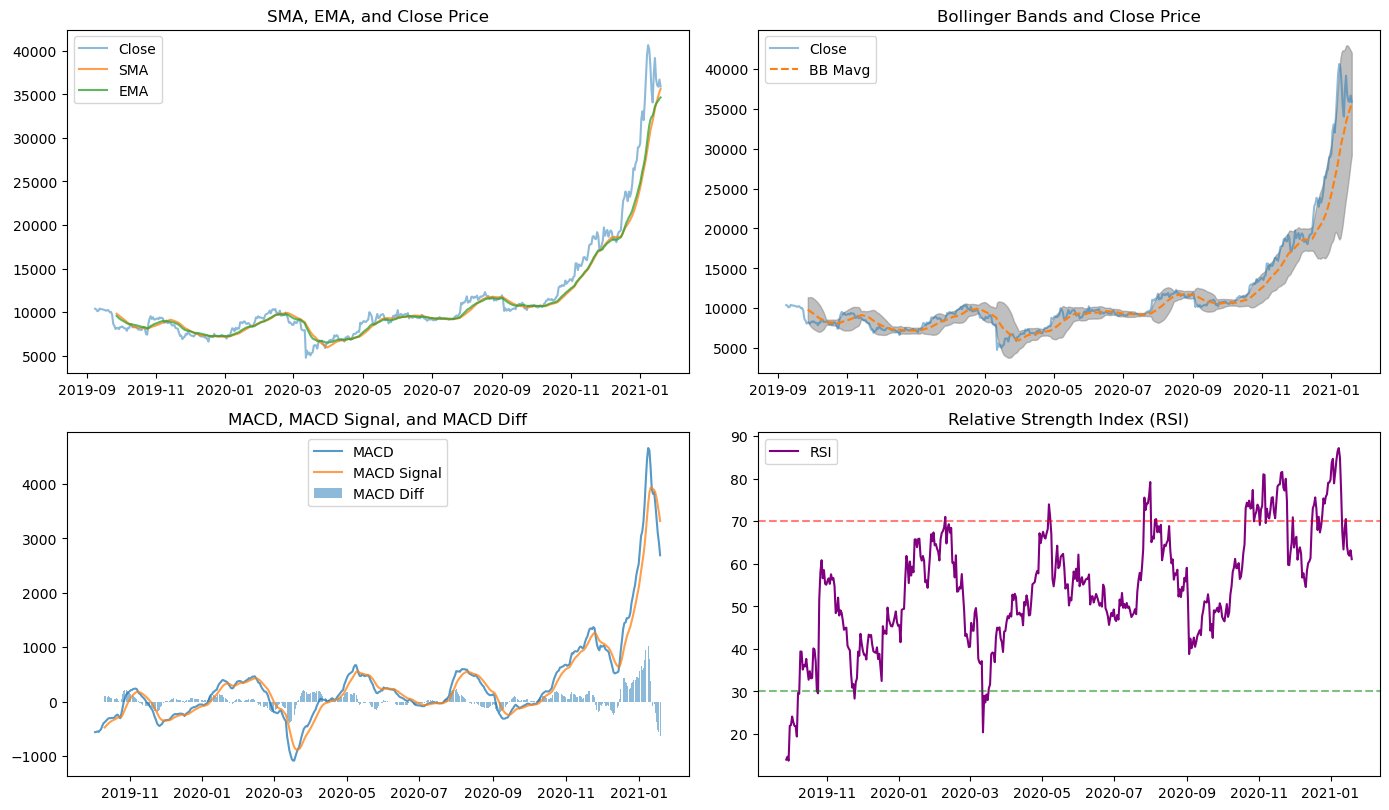

In [41]:
plot_at_metrics(results_metrics_1d['BTC'])

Maybe looking for other timestamps might be more interesting than 15m for the RSI. 

In [42]:
print("The time series is likely non-stationary.") if adfuller(results_metrics_1d['BTC']['rsi'].dropna(axis = 0))[1] > 0.05 else print("The time series is likely stationary.")

The time series is likely stationary.


In [43]:
#Simple moving average
print("The time series is likely non-stationary.") if adfuller(results_metrics_1d['BTC']['sma'].dropna(axis = 0))[1] > 0.05 else print("The time series is likely stationary.")

The time series is likely non-stationary.


In [44]:
#Exponantial moving average
print("The time series is likely non-stationary.") if adfuller(results_metrics_1d['BTC']['ema'].dropna(axis = 0))[1] > 0.05 else print("The time series is likely stationary.")

The time series is likely non-stationary.
